In [25]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltk.corpus import sentiwordnet as swn
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

In [7]:
def all_synsets(text):
    return [list(swn.senti_synsets(token)) for token, pos in text]

def sum_strategy(text):
    s = np.zeros(3)
    all_s = all_synsets(text)
    for i, (token, pos) in enumerate(text):
        try:
            synsets = all_s[i]
            sidf = np.log(max([len(l) for l in all_s]) / len(synsets))
            for syn in synsets:
                p, n, o = syn.pos_score(), syn.neg_score(), syn.obj_score()
                s[0] += p * sidf
                s[1] += n * sidf
                s[2] += o * sidf
        except ZeroDivisionError:
            pass
    return s

In [8]:
yelp_file = 'data/yelp_example_1.json'
with open(yelp_file, 'r') as infile:
    data = json.load(infile)

In [9]:
docs = data['docs']
titles = data['titles']
scores = data['scores']

In [10]:
Xd = {}
for i, text in enumerate(docs):
    Xd[i] = sum_strategy(text)

In [15]:
X = pd.DataFrame(Xd).T
X.columns = ['p', 'n', 'o']
scaler = MinMaxScaler()
Xs = scaler.fit_transform(X)

In [26]:
Xs

array([[0.03065502, 0.01385133, 0.0267167 ],
       [0.03084345, 0.01903383, 0.02808522],
       [0.02202849, 0.01827383, 0.02159697],
       ...,
       [0.13972425, 0.09237526, 0.12500278],
       [0.01003459, 0.03666133, 0.01928596],
       [0.12729151, 0.05154951, 0.08182121]])

In [27]:
V = PCA(n_components=2).fit_transform(Xs)

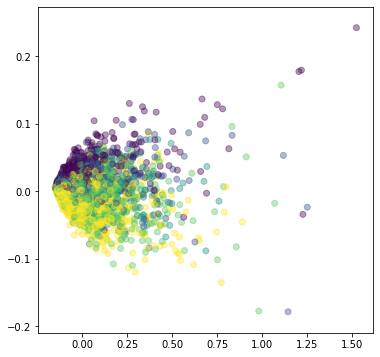

In [28]:
fig, ax = plt.subplots(figsize=(6, 6), nrows=1, ncols=1)
ax.scatter(V[:,0], V[:,1], c=scores, alpha=0.4)
plt.show()

In [29]:
T = pd.DataFrame(Xs, columns=['p', 'n', 'o'])
T['target'] = scores

In [30]:
T.corr()

,p,n,o,target
p,1.000000,0.915813,0.950347,-0.073484
n,0.915813,1.000000,0.958225,-0.258284
o,0.950347,0.958225,1.000000,-0.172978
target,-0.073484,-0.258284,-0.172978,1.000000


In [33]:
from sklearn.cluster import KMeans

In [35]:
k = KMeans(n_clusters=5)
y_pred = k.fit_predict(Xs)

In [36]:
y_pred

array([3, 3, 3, ..., 0, 3, 0], dtype=int32)

In [42]:
from sklearn.metrics import adjusted_rand_score, confusion_matrix, ConfusionMatrixDisplay

In [38]:
adjusted_rand_score(scores, y_pred)

0.05346715493037167

In [40]:
cm = confusion_matrix(scores, y_pred)

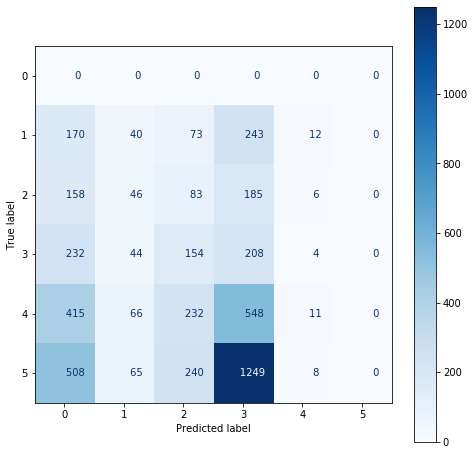

In [46]:
fig, ax = plt.subplots(figsize=(8, 8))
d = ConfusionMatrixDisplay(cm, [0, 1, 2, 3, 4, 5])
d.plot(cmap=plt.cm.Blues, ax=ax, values_format='10.0f')
plt.show()

In [45]:
print(set(scores))

{1, 2, 3, 4, 5}


## Supervised

In [49]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB

In [50]:
X_train, X_test, y_train, y_test = train_test_split(
    Xs, scores, test_size=0.2, random_state=42)

In [52]:
y_pred = GaussianNB().fit(X_train, y_train).predict(X_test)

In [54]:
cm = confusion_matrix(y_test, y_pred)

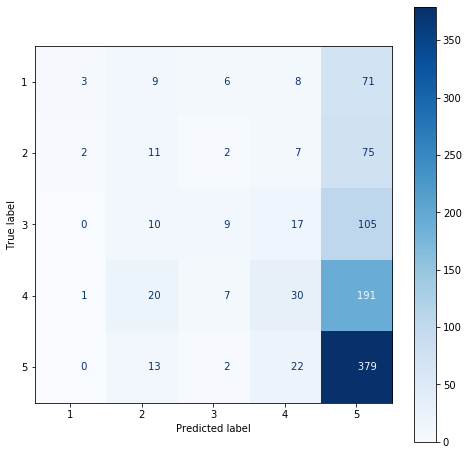

In [55]:
fig, ax = plt.subplots(figsize=(8, 8))
d = ConfusionMatrixDisplay(cm, [1, 2, 3, 4, 5])
d.plot(cmap=plt.cm.Blues, ax=ax, values_format='10.0f')
plt.show()

In [56]:
from sklearn.metrics import classification_report

In [57]:
report = classification_report(y_test, y_pred)

In [58]:
print(report)

              precision    recall  f1-score   support

           1       0.50      0.03      0.06        97
           2       0.17      0.11      0.14        97
           3       0.35      0.06      0.11       141
           4       0.36      0.12      0.18       249
           5       0.46      0.91      0.61       416

    accuracy                           0.43      1000
   macro avg       0.37      0.25      0.22      1000
weighted avg       0.40      0.43      0.33      1000

